 # Lesson Bayes
 Rev 2.1: 2-27-22

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from scipy import stats

<img src="img/BayesianUpdate.png" width="1200">

Remember this slide from the earlier lesson. In this lesson we're going to talk through each step

## Breaking down the A/B Test model

In [9]:
# Generate random data to see if we can recover parameters in this lesson
np.random.seed(3)
n_visitors = 1000
conversion_rate=.3

# Simulate 286 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

with pm.Model():
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    
    # likelihood of observing data given parameter
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # Posterior Estimation
    idata = pm.sample()
    
    # Prior Predictive
    idata.extend(pm.sample_prior_predictive())
    
    # Posterior Predictive
    idata.extend(pm.sample_posterior_predictive(idata))
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Prior Distribution
* How to incorporate domain knowledge into models
* Regularization for Bayesian Models


## Likelihood Distribution
* The measure of our observation plausibility
* The connected between the data and our parameters

## Posterior Distribution
* The distribution every Bayesian wants
* Our updated beliefs after incorporating the data

## The predictive distributions
  * Going the other way, from parameter space to data space
  * Two types
      * Prior Predictive
      * Posterior Predictive

## Markov Chain Monte Carlo
* The computational sampling algorithm that makes Modern Bayes possible
    * This is the core of the magic machine

## Bayes Formula

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Specifically we're going to go through each one of these terms and talk through the their theoretical meaning and their practical intuition

# Priors
Expressing plausibility before seeing data

$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{{p(\boldsymbol{Y})}}
$$

<img src="img/PriorSlide.png" width="1200">

## A/B Testing: What do we know before we see the data?
Before running the experiment what do we believe the conversion ratio could be?

* Any value between 0% and 100% equally?
* Probably 20% based on past experience?
* Definitely not above 40%?

## Priors distributions codify expert knowledge
Each of these distributions showcase a different belief

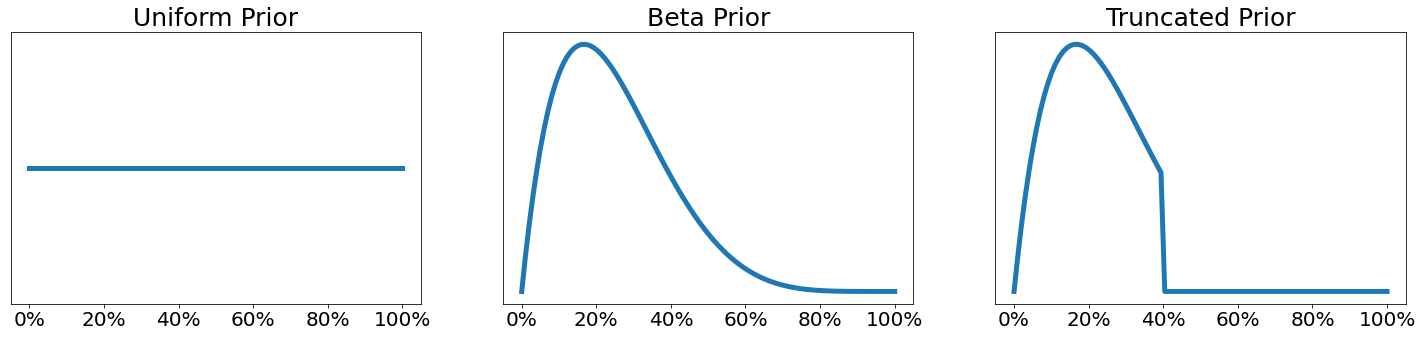

In [10]:
import matplotlib.ticker as mtick

def priors(labels):
    fig, axes = plt.subplots(1, 3, figsize=(25,5))

    x = np.linspace(0,1,100)

    unif = stats.uniform(0,1)
    axes[0].plot(x, unif.pdf(x), lw=5)
    axes[0].set_title(labels[0], fontsize=25)

    beta = stats.beta(2,6)
    axes[1].plot(x, beta.pdf(x), lw=5)
    axes[1].set_title(labels[1], fontsize=25)


    truncated = stats.beta(4,12)
    pdf = beta.pdf(x)
    pdf[x>.4] = 0
    axes[2].plot(x, pdf, lw=5)
    axes[2].set_title(labels[2], fontsize=25)

    for ax in axes:
        ax.set_yticks([])
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.tick_params(axis="x", labelsize=20)
    return 

labels = ["Uniform Prior", "Beta Prior", "Truncated Prior"]
priors(labels)

## Expressing a prior in PyMC

In [11]:
with pm.Model() as model_a:
    
    # Parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

## The rationale behind the prior is what's important

You may be now thinking "Well how do I know the right/best/correct prior?" The truth is you won't.

There's a famous quote stating "All models are wrong, some are useful"

When selecting priors the task is not to pick the right prior *independent of any other factor*, but one that you can justify in context with
* the rest of the model
* how your model will be used in reality
* the experience of domain experts

## Priors are a form of regularization


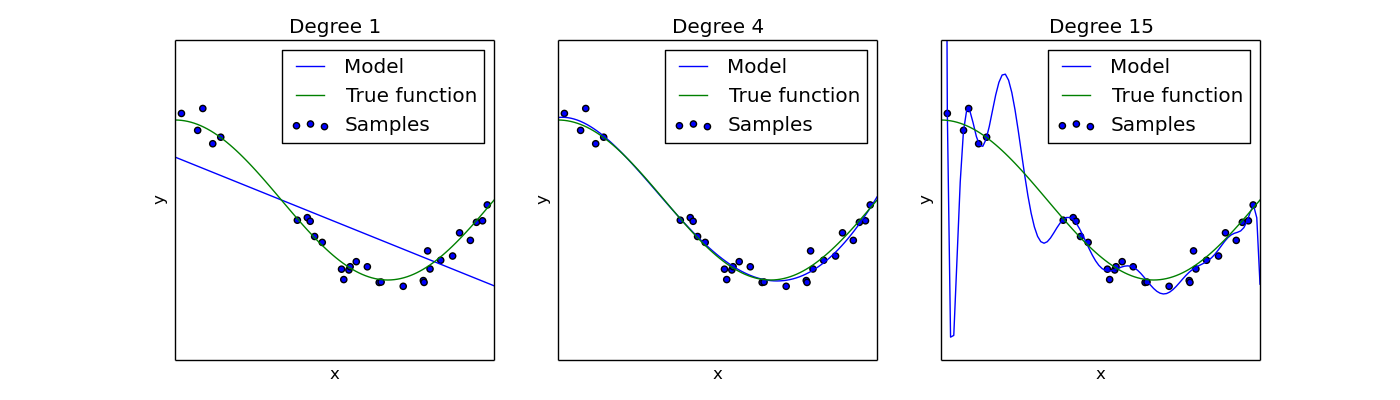
**Source**: scikit-learn documentation

Another benefit of priors is they can be utilized to focus the models on reasonable possibilities and not far flung parameters that happen optimize a metric.

In other words we can use priors to
* Highlight reasonable possible parameters
* Penalize unreasonable possible parameters

For example in the case below if we were using a Bayesian model to estimate the degree of fit of a polynomial, we could choose to put a prior with high beliefs on polynomial degree 2-6, but lesser belief on 0, 1 and greater than 8

## Section Recap
* Priors distributions express the plausibility of parameters prior to seeing data
* When choosing a prior focus on the rationale behind the prior
  * not picking the "right" prior


# Likelihoods
The plausibility of the data given a parameter  


$$ 
p(\boldsymbol{\theta} \mid \boldsymbol{Y}) = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{Likelihood}}\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

<img src="img/LikelihoodSlide.png" width="1200">

# The connection between data space and parameter space

```python
likelihood = pm.Binomial("likelihood", 
                            p=conversion_rate, 
                            n=n_visitors,
                            observed=observed_conversions)
```

## Ranking possible conversion values?
For our A/B test example let's say we on variant B we see *100* visits and *85* of them convert.

What is the plausibility that the true conversion rate, p(conversion) is:
* 1%
* 100%
* 80%
* 95%

Pause the video here and rank these from most to least plausible before continuing on

## Intuitively ranking `p(conversion)` values?

1. 80%
2. 95%
3. 1%
4. 100%



Out of 100 visits, 85 converted. That brings us to an *empirical* conversion rate of 85%, but as Bayesians we also want to know the plausibility of all other conversion rates.

Intuitively we know a 100% conversion rate impossible. If even 1 person didn't convert the true conversion rate can't be 100%.

1% is highly implausible but *it is still possible*. It may be that in our sample of 100 we were lucky to get 85, but it's not likely.

Intuition may not be enough to differentiate  80% and 95%, let's show how to calculate likelihood

## Calculating Likelihood is just calculated PDF

In [12]:
num_conversions, num_visitors = 85, 100
possible_true_conversion_rate = .80

binom = stats.binom(p=possible_true_conversion_rate, n=num_visitors)
binom.pmf(num_conversions)

0.0480617937007464

The calculation for a likelihood is just calculating the PDF! We plug in a possible conversion value, and the data and we get a value back.

Remember though that the PMF, or PDF, values only mean something relative to each other. We need to compare our likelihood at 80% with the one at 95%



## Comparing Relative Likelihoods


In [13]:
multiple_possible_true_conversion_rates = [.01, .8, .95, 1]

binom = stats.binom(p=multiple_possible_true_conversion_rates, n=num_visitors)
binom.pmf(num_conversions)

array([2.17885869e-153, 4.80617937e-002, 9.88001628e-005, 0.00000000e+000])

The results match our intuition. 100% conversion is impossible, given a value of zero, 1% is highly unlikely, and comparing 80% and 95%, 80% is more likely

This is great, now we have a way of quantifying the plausibility of the observed data given a parameter.

Let's use a handy trick from SciPY where we can plug in all four parameter values and calculate the likelihood in one go.

## What is the most plausible line?


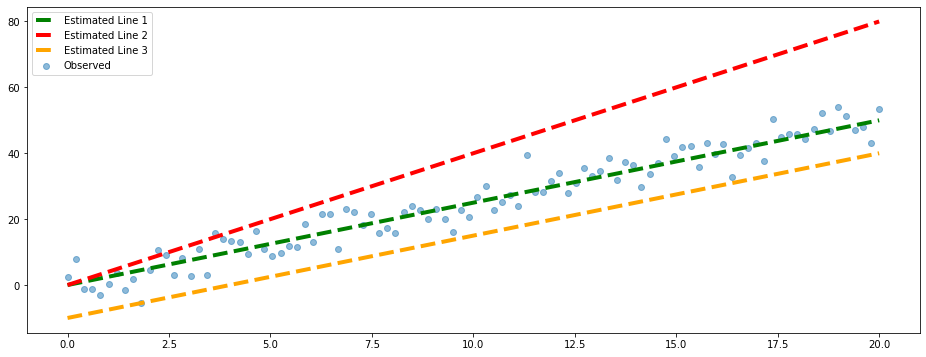

In [14]:
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)
x = np.linspace(-0, 20, 100)
slope_true = 2.5

y_obs = x*slope_true + stats.norm(0,4).rvs(100)

fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(x, y_obs, alpha=.5, label="Observed")

lw=4
ax.plot(x, slope_true*x, c="g", lw=lw, ls="--", label="Estimated Line 1" )
ax.plot(x, 4*x, c="r", lw=lw, ls="--", label="Estimated Line 2")
ax.plot(x, (slope_true*x) -10, c="orange", lw=lw, ls="--", label="Estimated Line 3")

plt.legend();

Plausibility can exist in more than two dimensions
Linear regressions have at least two parameters, but all the same concepts apply

Which line seems the most plausible to you? The red one seems to have the right intercept, but the wrong slope.
The yellow one has the right slope by wrong intercept
The green one seems to get both right and fits the data well.

When we revisit linear regression later in the course, remember this inuition

## PyMC will automatically calculate likelihood


In [15]:
with pm.Model():
    
    # Parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)
    
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)

Now that you know the fundamental math and have an intuition behind likelihood I'm happy to tell you, PyMC will do all the work for you.

All you need to do is specify the likelihood distribution is add `observed` as an argument. Remember likelihood is the link between parameter space and observed space.

With all that you're prepped for the next, and most important topic, getting the posterior

## Section Recap
* Likelihood measures the plausibility of parameters given data
    * It answers the question "Given this observed data what parameters are the most likely to have produced it?"
* Likelihood is measured by the PDF or PMF the data given a fully specified distribution

# Posterior
The coveted distribution that enables *inference*

$$ 
\overbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}^{\text{Posterior}} = \frac{p(\boldsymbol{Y} \mid \boldsymbol{\theta})\; p(\boldsymbol{\theta})}{{p(\boldsymbol{Y})}}
$$

## The fundamental question
If we observe something, what can we infer?

Or as statistician would say 

If we have 
1. *observed samples* from the world
2. a *model* of how the world works
3. a *prior* belief

What is our updated belief after seeing our observations? 

It's the posterior distribution

<img src="img/PosteriorSlide.png" width="1200">

## The magic inference button

In [16]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # The magic inference Button
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Remember, to get a posterior we need
* Prior(s)
* Data
* Likelihood

Once we express these in PyMC all we need to do is hit the magic inference button

## Our posterior samples

In [17]:
idata.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    conversion_rate  (chain, draw) float64 0.2927 0.2933 ... 0.3202 0.3163
Attributes:
    created_at:                 2022-04-26T05:02:04.536687
    arviz_version:              0.12.0
    inference_library:          pymc
    inference_library_version:  4.0.0b5
    sampling_time:              1.2448558807373047
    tuning_steps:               1000

## We get 30% (almost)

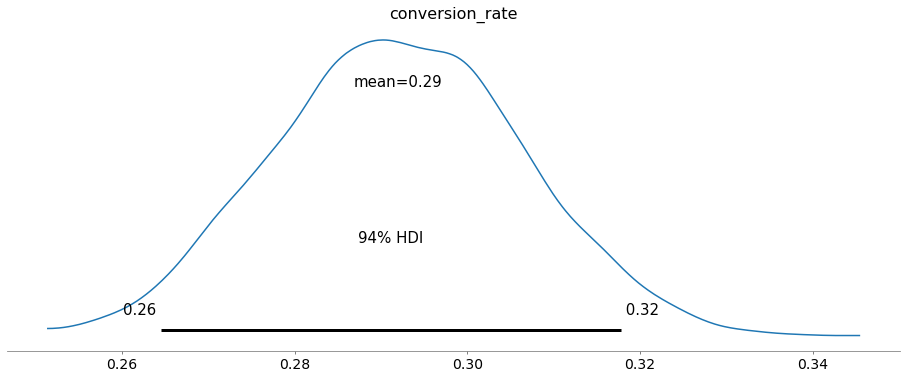

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))
az.plot_posterior(idata.posterior, ax=ax);

With that PyMC combines the prior distribution, likelihood distribution, and data together and is able to estimate our hidden conversion rate that we set at the start of the lesson!

## Everything all together

In [19]:
# Generate random data to see if we can recover parameters in this lesson
np.random.seed(3)
n_visitors = 1000
conversion_rate=.3

# Simulate 1000 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("likelihood", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # The magic inference Button
    idata = pm.sample()
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


To show you that I don't have any tricks up my sleeve let's do this together. One of your optional exercises will be to generate a simulated AB test run, share it with

# Change the prior and data and see the effects
Download this notebook and change the prior and data and see what happens. Try using
* A wide prior
* More observations
* Less observations
* Different level of conversions

You've seen MCMC many times now, and now you have sense of what its doing. By usising distributions that define PMF and PDF, calculating likelihoods, and testing specific parameters in a specialized way its able to help us perform inference.

# Section Recap
* Posterior distributions 
    * allow us to perform *inference* the goal of statistics
    * incorporate the data, the model, and our priors
* Bayesian updating is the process of combining prior, likelihood, data
* Posterior estimation is not always "easy or straightforward"
    * PPLs typically estimate the posterior with a sampling technique called MCMC 

# Prior and Posterior distributions
From parameter space to observed data space


<img src="img/PredictiveDistributions.png" width="1200">

## Parameter Space
So far with prior, and posterior we've been in parameter space, estimating conversion rate, but if we want to know how many people we believe will convert, that is what we will observe

## Prior Predictive


In [66]:
with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("num_conversions", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    prior_a = pm.sample_prior_predictive()
   

In [67]:
prior_a

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

What data do we expect to see just based on our prior knowledge

* Lets us understand our priors
* Test our model is specified correctly

## Plotting our Prior predictive

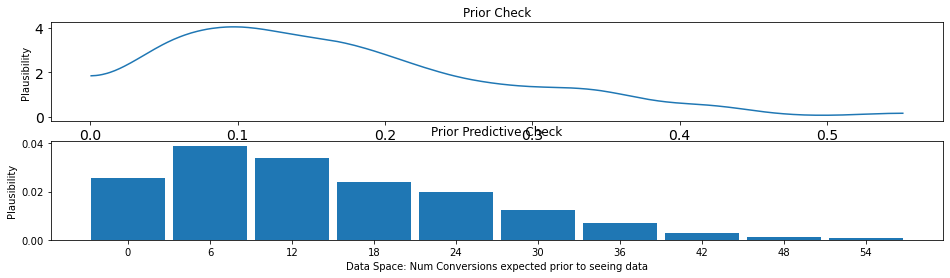

In [71]:
fig, axes = plt.subplots(2, 1, figsize=(16,4), sharex=False)
az.plot_dist(prior_a.prior["conversion_rate"], ax=axes[0])
axes[0].set(xlabel="Parameter Space: Prior conversion rate", ylabel="Plausibility", title="Prior Check")

az.plot_dist(prior_a.prior_predictive["num_conversions"], ax=axes[1])
axes[1].set(xlabel="Data Space: Num Conversions expected prior to seeing data", 
       ylabel="Plausibility", 
       title="Prior Predictive Check");

## Posterior Predictive

In [60]:
# Generate random data to see if we can recover parameters in this lesson
np.random.seed(3)
n_visitors = 100
conversion_rate=.3

# Simulate 1000 visits
observed_visits = stats.bernoulli(p=conversion_rate).rvs(n_visitors)
observed_conversions = observed_visits.sum()

with pm.Model() as ab_test_model:
    
    # parameter we want to infer with prior
    conversion_rate = pm.Beta("conversion_rate", 2, 10)

    
    # Connection between parameter and observations
    likelihood = pm.Binomial("num_conversions", 
                                p=conversion_rate, 
                                n=n_visitors,
                                observed=observed_conversions)
    
    # The magic inference Button
    idata = pm.sample()
    
    # Posterior Predictive
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9107, but should be close to 0.8. Try to increase the number of tuning steps.


We only need to add one extra line to generate a posterior predictive

In [61]:
idata.posterior_predictive.num_conversions

<xarray.DataArray 'num_conversions' (chain: 4, draw: 1000)>
array([[26, 22, 14, ..., 17, 17, 26],
       [21, 22, 18, ..., 20,  9, 17],
       [22, 12, 13, ..., 21, 23, 28],
       [30, 18, 27, ..., 18, 13, 16]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

We get arrays of simulated futures, conditioned on what we've seen previously!

This shows us before we incorporate data. Let's use PyMC to generate this its quite easy its only one line. Note we don't even need to sample posterior, remember this is the distribution *before* we incorporate any data

Why is posterior predictive useful

* Sometimes were not interested in the parameters at all, but only what we believe will happen. You'll see that in the next lesson
* Other times we need to make a decision. Posterior predictive gives us not only the most likely future, but every single possible future weighted with the probability it will happen

## Generative modeling
These tools are possible because Bayesian models are generative, meaning they can generate outcomes. This is an incredible benefit over discriminative models, which can only point to pick between set outcomes, but not generate all possible outcomes

## Section Recap
Generative distributions are
* Super useful
* Very easy to obtain using PyMC
* A huge capability not available with many other stats methods

# Markov Chain Monte Carlo
The magic behind the magic inference button

## All you need to know
* Markov Chain Monte Carlo magic part of the magic machine
* It uses computational samples to estimate the posterior
* Modern versions are very flexible and very fast
  * Pay attention to the diagnostics though!

##  What's the magic inference button doing 

It's using Markov Chain Monte is a sampling based algorithm

* Works well on many models relatively automatically
* Is efficient and returns results relatively quickly
* Is pretty good at getting the right result
  * But if it can't comes with a good set of diagnostics to guide you


## Building our own engine
* You will never need to do this
* The version we're building here is not good

In [38]:
# A smaller observed set for computational stability
observed_visits = [0,0,0,1,1]

# Manual calculation of the posterior
def post(θ, observed, α=1, β=1):
    if 0 <= θ <= 1:
        
        # Prior
        prior = stats.beta(α, β).pdf(θ)
        
        # Likellihood
        like  = stats.bernoulli(θ).pmf(observed).prod()
        
        # Multiplication
        prob = like * prior
    else:
        
        # If out of bounds 
        prob = -np.inf
    return prob

## Steps of MCMC algorithm

1. Get the posterior value of where you are
2. Randomly select another parameter
3. Calculate posterior value at new parameter value
4. Calculate ratio

5. Draw a random value from a uniform distribution
6. If value from uniform distribution is lower move to new position
   * Otherwise stay where you are and try again
   
 
Repeat many more times

## Sample Code

```python
n_iters = 10000
can_sd = 0.05
α = β =  1
θ = 0.5

trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, observed_visits, α, β)

for iter in range(n_iters):

    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, observed_visits, α, β)
    pa = p1 / (p2)
        
    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ
```

Here's what the code looks like. We won't run this here 

## MCMC Sampling in Action
<br>
<center> <video src="img/SamplerVideo.mp4" width="1000"/></center>

## Original Version: Metropolis Hasting
<img src="img/OldCar.png" width="1200">

What we've implemented here is a version of MCMC called Metropolis Hastings. It's one of the initial versions of MCMC and like this car here. while it works it's it slow, inefficient, and tends to require a lot of hand tuning to get it to work juuusstt right

## Modern Speed Machine: HMC
<img src="img/Formula1Car.png" width="1000">

Modern PPls like PyMC use a much better version of MCMC called Hamiltonian Monte Carlo, or HMC for short. Like this F1 car it still uses the original principle, but has additional updates and systems that make it wayyy faster and easier to use.

When you see the line "Using NUTS" in PyMC thats HMC.



## Section Summary
* Markov Chain Monte Carlo magic part of the magic machine
* It uses computational samples to estimate the posterior
* Modern versions are very flexible and very fast
  * Still requires checking with diagnostics

# Lesson Summary
Unfinished for now

* The three terms we care about in Bayes Rule
  * And the one we don't
* The different types of priors
  * Informative 
  * Uninformative
* How to calculate likelihood given data
* How to calculate a simple posterior